In [1]:
from pymongo import MongoClient
import pandas as pd
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt
import scipy
from pymatgen.io.cif import CifParser
import ase
import jax.numpy as jnp
import numpy as np
from sklearn.cluster import KMeans
import torch
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import src.spectra as spectra
import warnings
warnings.filterwarnings("ignore")

client = MongoClient()
db = client['spectra_database']
collection = db['mp_AgS_bispectra_lmax_4_min_dist_cutoff']
# collection = db['csd_AgS_bispectra_lmax_4_min_dist_cutoff']
data = collection.find()
df = pd.DataFrame(list(data))
df = df.drop('_id', axis=1)


In [2]:
AgS_only = df[df['local_elements'].apply(lambda x: len(set(x)) == 1)]
AgS_only_bispectra = list(AgS_only.bispectrum)
AgS_others = df[df['local_elements'].apply(lambda x: len(set(x)) != 1)]
AgS_others_bispectra = list(AgS_others.bispectrum)


In [3]:
# Linear
bent_linear = jnp.array([
    [1, 0, 0],
    [np.cos(np.pi*11/12), np.sin(np.pi*11/12), 0]
])

# Trigonal planar
trigonal_planar = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0]
])

# Bent (assume 120 degrees)
bent_120 = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0]
])

# Tetrahedral
tetrahedral = jnp.array([
    [0, 0, 1],
    [0.943, 0, -0.333],
    [-0.471, 0.816, -0.333],
    [-0.471, -0.816, -0.333]
])

# Seesaw
seesaw = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]
])

# T-shaped
t_shaped = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0]
])

# Octahedral
octahedral = jnp.array([
    [1, 0, 0],
    [-1, 0, 0],
    [0, 1, 0],
    [0, -1, 0],
    [0, 0, 1],
    [0, 0, -1]
])

trigonal_prism = jnp.array([
    [1, 0, 0],
    [-0.5, jnp.sqrt(3)/2, 0],
    [-0.5, -jnp.sqrt(3)/2, 0],
    [1, 0, 1],
    [-0.5, jnp.sqrt(3)/2, 1],
    [-0.5, -jnp.sqrt(3)/2, 1]
])

one_neighbor = jnp.array([
    [1, 0, 0]
])

common_geometries = {
    '(Bent) Linear': bent_linear,
    'Trigonal Planar': trigonal_planar,
    'Tetrahedron': tetrahedral,
    'T-shape': t_shaped,
    'Octahedron': octahedral,
    'Trigonal Prism': trigonal_prism,
    'Seesaw': seesaw,
    'One (S) Neighbor': one_neighbor
}

colors = {
    '(Bent) Linear': '#febd2a',
    'Trigonal Planar': '#f48849',
    'Tetrahedron': '#db5c68',
    'T-shape': '#8b0aa5',
    'Octahedron': '#5302a3',
    'Trigonal Prism': '#0d0887',
    'Seesaw': '#b83289',
    'One (S) Neighbor': '#f0f921'
}

bispectrum = spectra.Spectra()
for label, geometry in common_geometries.items():
    spectrum = np.array(bispectrum.compute_geometry_spectra(geometry))
    common_geometries[label] = spectrum / np.linalg.norm(spectrum)

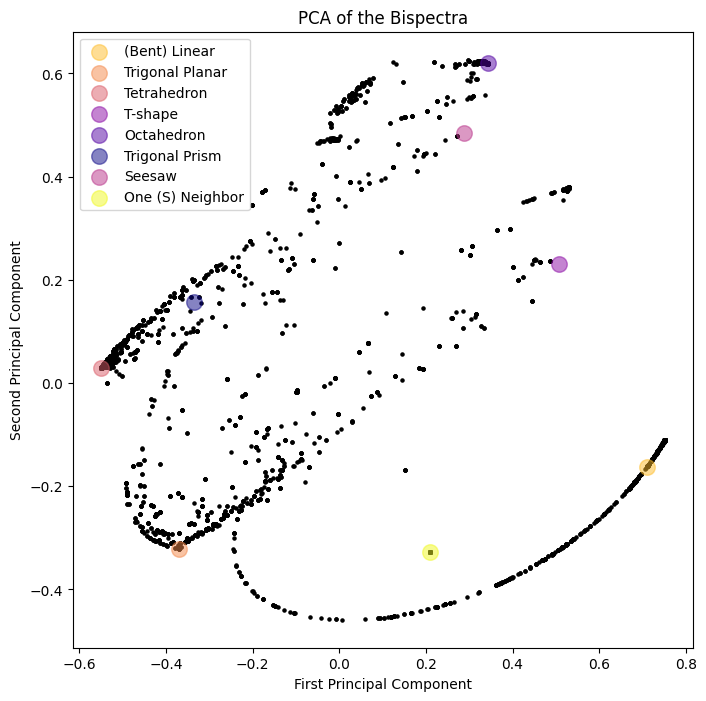

In [4]:
for i in range(len(AgS_only_bispectra)):
    AgS_only_bispectra[i] = AgS_only_bispectra[i] / np.linalg.norm(AgS_only_bispectra[i])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(AgS_only_bispectra)

plt.figure(figsize=(8, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=['black'], s=5)
plt.title('PCA of the Bispectra')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

for label, geometry in common_geometries.items():
    pca_result = pca.transform([geometry])[0]
    plt.scatter(pca_result[0], pca_result[1], marker='.', s=500, alpha=0.5, color=colors[label], label=f"{label}")

plt.legend()
